In [1]:
#import multiprocessing as mp
#mp.set_start_method("spawn", force=True)

import os
os.environ["HYDRA_FULL_ERROR"] = "1"

import hydra
with hydra.initialize('config', version_base='1.3'):
    cfg = hydra.compose("main", overrides=[
        'xp= unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_rec'#unet_uv_drifters_dask
    ])

mutivar_da = hydra.utils.call(cfg.datamodule.multivar_da)

dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup() # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api*

train_dl = dm.test_dataloader() # # Split data into batch, selection of the etrainuation data + Computation of norm / Augmentation
train_ds = train_dl.dataset 
input_data = train_ds

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


init open_multivar_datasets
RAM = 0.58 Go
{'lat': slice(27, 49, None), 'lon': slice(-136, -109, None), 'time': slice('2019-12-01', '2020-01-10', None)}

handling [ssh] var
for var open_multivar_datasets
RAM = 0.58 Go
<xarray.DataArray 'ssh' (time: 41, lat: 88, lon: 108)> Size: 2MB
[389664 values with dtype=float32]
Coordinates:
    Lambert_Azimuthal_Grid  int32 4B ...
  * time                    (time) datetime64[ns] 328B 2019-12-01 ... 2020-01-10
  * lat                     (lat) float32 352B 27.16 27.41 27.66 ... 48.69 48.94
  * lon                     (lon) float32 432B -136.0 -135.7 ... -109.5 -109.2
Attributes:
    long_name:              absolute dynamic topography
    units:                  m
    description:            ADT from CNES/CLS MDT + SLA mapped using SimVP_SS...
    standard_name:          sea_surface_height_above_sgeoid
    coverage_content_type:  modelResult
    valid_range:            [-1.e+09  1.e+09]
    grid_mapping:           crs
    comment:                Abs

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:

from pytorch_lightning import Trainer

trainer = Trainer(
  inference_mode=False,
  gradient_clip_val=0.5,
  accelerator='gpu',
  devices=1,
  #fast_dev_run=True,
  limit_train_batches=0.8,  # Utilise seulement 10% des batches d'entraînement
  limit_val_batches=0.8,    # Utilise seulement 10% des batches de validation
) 

import torch 
lit_mod = hydra.utils.call(cfg.model)
ckpt = "/Odyssey/private/t22picar/multivar_drifter/outputs/saved/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/checkpoints/val_total_mse=0.10336-epoch=076.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


n_channels
77
n_classes
22


In [7]:
print(f"loading from ckpt {ckpt}")
lit_mod.load_state_dict(
    torch.load(ckpt, weights_only=True)['state_dict']
)

trainer.test(lit_mod, datamodule=dm, ckpt_path=ckpt)

loading from ckpt /Odyssey/private/t22picar/multivar_drifter/outputs/saved/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/checkpoints/val_total_mse=0.10336-epoch=076.ckpt


Restoring states from the checkpoint path at /Odyssey/private/t22picar/multivar_drifter/outputs/saved/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/checkpoints/val_total_mse=0.10336-epoch=076.ckpt


Norm stats defined (array([ 4.30138946e-01,  2.02724468e-02,  1.01279770e-03,  1.18275523e-01,
        1.12506501e-01,  2.62093283e-02,  8.73786863e-03, -7.36356247e-03,
        3.97375439e+03]), array([2.07894295e-01, 9.75202173e-02, 8.88478979e-02, 1.68560958e+00,
       1.40871561e+00, 3.19744706e-01, 2.63232410e-01, 7.63729477e+00,
       5.87686096e+02]))


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
LOCAL_RANK: 0 

Testing DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 37.26it/s]clear_gpu_mem
TEST DATA SIZE: torch.Size([31, 2, 11, 88, 108])
total reconstruction time: 0.069
| Metrics   |
|-----------|
/Odyssey/private/t22picar/multivar_drifter/lightning_logs/version_22532/test_data_dim0.nc
total reconstruction time: 0.048
| Metrics   |
|-----------|
/Odyssey/private/t22picar/multivar_drifter/lightning_logs/version_22532/test_data_dim1.nc
Testing DataLoader 0: 100%|██████████| 31/31 [00:01<00:00, 24.48it/s]


[{}]

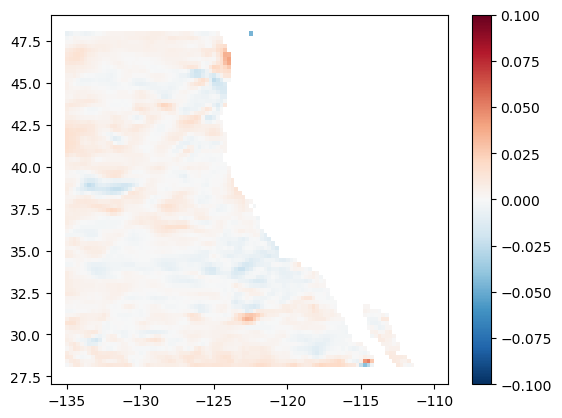

In [9]:
import xarray as xr 

time_target='2019-12-15'
#result_filepath = "/Odyssey/private/t22picar/multivar_uv/rec/ssh_duacs_sst_w_to_u_v_11d_15m_psi/daily/unet_rec_2019-01-01.nc"
result_filepath =  f"/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost/daily/unet_rec_{time_target}.nc"
res_data = xr.open_dataset(result_filepath)
res_data = res_data.sel(lon=slice(-136.1,-109.1)).sel(lat=slice(27.15,48.95))

result_filepath =  "/Odyssey/private/t22picar/multivar_drifter/lightning_logs/version_22532/test_data_dim0.nc"
test_u0 = xr.open_dataset(result_filepath).sel(time=time_target).sel(lon=slice(-136.1,-109.1)).sel(lat=slice(27.15,48.95))

import matplotlib.pyplot as plt
plt.pcolormesh(test_u0.lon,test_u0.lat,res_data.ugos-test_u0.out,vmin=-0.1,vmax=0.1,cmap=plt.cm.RdBu_r)
plt.colorbar()

In [11]:
batch = next(enumerate(input_data))[1]

In [13]:
batch.shape

(9, 11, 560, 1440)

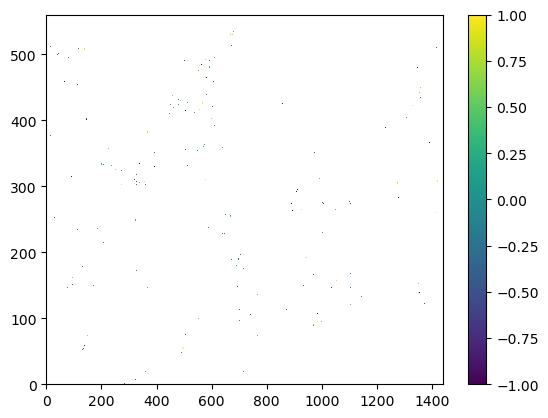

In [3]:
import matplotlib.pyplot as plt
plt.pcolormesh(batch[-1,0,:],vmin=-1,vmax=1)
plt.colorbar()

(array([0.00235777, 0.        , 0.00157185, 0.00235777, 0.00078592,
        0.00157185, 0.00157185, 0.00392962, 0.00235777, 0.0031437 ,
        0.0031437 , 0.        , 0.        , 0.00078592, 0.00235777,
        0.00157185, 0.00157185, 0.00550147, 0.00235777, 0.00235777,
        0.00235777, 0.00235777, 0.00235777, 0.0031437 , 0.00392962,
        0.00550147, 0.00628739, 0.00550147, 0.00943109, 0.00628739,
        0.00785924, 0.00707332, 0.00707332, 0.00864517, 0.00785924,
        0.01336071, 0.01650441, 0.01807626, 0.01886218, 0.02436366,
        0.02829328, 0.03065105, 0.03693845, 0.03300882, 0.05187101,
        0.04951324, 0.07544874, 0.07780651, 0.10374202, 0.08802353,
        0.14618193, 0.18705   , 0.18705   , 0.26957206, 0.29472164,
        0.41968362, 0.467625  , 0.55643446, 0.64760168, 0.61930841,
        0.53285673, 0.46998278, 0.43304433, 0.36702668, 0.30651051,
        0.24285063, 0.21062773, 0.18076261, 0.13675084, 0.13203529,
        0.08959538, 0.07387689, 0.06523172, 0.05

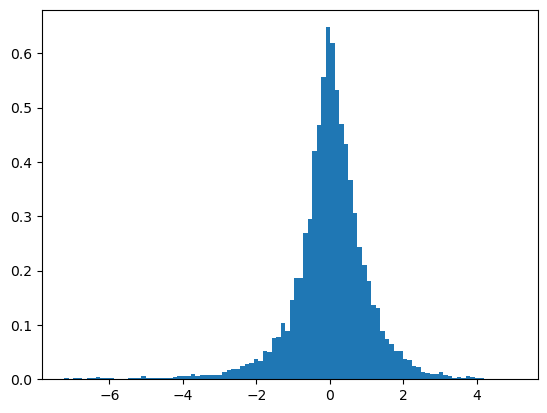

In [4]:
import numpy as np 
test = batch[-1,:,:,:]
plt.hist(test[~np.isnan(test)],density=True,bins=100)


In [ ]:


import torch 
lit_mod = hydra.utils.call(cfg.model)

trainer.fit(lit_mod, datamodule=dm)

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Odyssey/private/t22picar/miniforge3/envs/4dvarnet-d ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


n_channels
11
n_classes
22


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Odyssey/private/t22picar/multivar_drifter/lightning_logs/version_20844/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Norm stats defined (array([0.37445721, 0.02024231, 0.00571528]), array([0.70046067, 0.30372316, 0.26359564]))



  | Name   | Type | Params | Mode 
----------------------------------------
0 | solver | UNet | 17.8 M | train
----------------------------------------
17.8 M    Trainable params
0         Non-trainable params
17.8 M    Total params
71.184    Total estimated model params size (MB)


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2:   0%|          | 0/17 [00:00<?, ?it/s, v_num=20844, val_u_drifter_mse=0.0916, val_u_drifter_loss=0.301, val_v_drifter_mse=0.0909, val_v_drifter_loss=0.345, val_total_mse=0.182, train_u_drifter_mse=0.0814, train_u_drifter_loss=0.268, train_v_drifter_mse=0.0879, train_v_drifter_loss=0.334, train_total_mse=0.169]         

Exception ignored in: <function _releaseLock at 0x74d9dd2a41f0>
Traceback (most recent call last):
  File "/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 2207682, 2207745) exited unexpectedly

In [ ]:
import time
# 4. Mesurer les performances
start_time = time.time()
for i, batch in enumerate(input_data):
    print(i)
    if i >= 10:  # Mesurer 10 batches
        break
end_time = time.time()

print(f"Temps pour 10 batches : {end_time - start_time:.2f} secondes")
print(f"Forme du batch : {batch.shape}")  # torch.Size([4, 100, 560, 1440])

0
1
2
3
4
5
6
7
8
9
10
Temps pour 10 batches : 4.44 secondes
Forme du batch : (3, 11, 560, 1440)


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Odyssey/private/t22picar/miniforge3/envs/4dvarnet-d ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


n_channels
11
n_classes
22


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Norm stats defined (array([0.37445721, 0.02024231, 0.00571528]), array([0.70046067, 0.30372316, 0.26359564]))


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Odyssey/private/t22picar/multivar_drifter/lightning_logs/version_20844/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB. GPU 0 has a total capacity of 44.29 GiB of which 44.75 MiB is free. Process 2849013 has 8.56 GiB memory in use. Process 2910216 has 406.00 MiB memory in use. Process 2912501 has 406.00 MiB memory in use. Process 3135836 has 406.00 MiB memory in use. Process 3150454 has 8.56 GiB memory in use. Process 2424310 has 712.00 MiB memory in use. Process 1940128 has 8.12 GiB memory in use. Process 1952046 has 8.77 GiB memory in use. Process 2190442 has 8.12 GiB memory in use. Including non-PyTorch memory, this process has 244.00 MiB memory in use. Of the allocated memory 68.83 MiB is allocated by PyTorch, and 13.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from torch.utils.data import IterableDataset
import torch as torch
import numpy as np 


def _dask_loader(dataset, batch_size=1, shuffle=True):
    """
    Générateur de batches à partir d'un dataset Dask.
    Compatible avec PyTorch Lightning sans num_workers.
    """
    idxs = np.arange(len(dataset))
    if shuffle:
        np.random.shuffle(idxs)

    for start in range(0, len(dataset), batch_size):
        batch_idxs = idxs[start:start+batch_size]
        batch = [dataset[i] for i in batch_idxs]  # __getitem__ gère Dask.compute()
        yield torch.stack(batch)

_dask_loader()


In [ ]:


class DaskIterableDataset(IterableDataset):
    def __init__(self, dask_array, batch_size):
        self.X = dask_array
        self.batch_size = batch_size

    def __iter__(self):
        n = self.X.shape[0]
        for i in range(0, n, self.batch_size):
            batch = self.X[i:i+self.batch_size].compute()
            yield torch.from_numpy(batch.astype(np.float32))

train_dl = dm.train_dataloader() # # Split data into batch, selection of the etrainuation data + Computation of norm / Augmentation
train_ds = train_dl.dataset 
input_data = train_ds

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
%reset -f

In [ ]:
#mutivar_da = hydra.utils.call(cfg.datamodule.multivar_da)

dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup() # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api*

train_dl = dm.train_dataloader() # # Split data into batch, selection of the etrainuation data + Computation of norm / Augmentation
train_ds = train_dl.dataset 
input_data = train_ds

In [ ]:
from pytorch_lightning import Trainer


trainer = Trainer(
  inference_mode=False,
  gradient_clip_val=0.5,
  accelerator='gpu',
  devices=1,
  #fast_dev_run=True,
  limit_train_batches=0.1,  # Utilise seulement 10% des batches d'entraînement
  limit_val_batches=0.5,    # Utilise seulement 10% des batches de validation
)

import torch 
lit_mod = hydra.utils.call(cfg.model)

trainer.fit(lit_mod, datamodule=dm)

In [ ]:
batch = next(enumerate(input_data))[1]

In [ ]:
batch = next(enumerate(input_data))[1]

In [ ]:
type(batch)

In [ ]:
import matplotlib.pyplot as plt 
plt.pcolormesh(batch[0,0,:])

In [ ]:
import torch
import dask.array as da
from torch.utils.data import Dataset, DataLoader


# 2. Définir le Dataset
class DaskDataset(Dataset):
    def __init__(self, dask_array):
        self.da = dask_array

    def __len__(self):
        return len(self.da)

    def __getitem__(self, idx):
        # Retourne un chunk Dask (sans .compute())
        return self.da[idx]

# 3. Définir collate_fn
def collate_fn(batch):
    # batch est une liste de Dask Arrays
    stacked = da.stack(batch, axis=0)  # Empile les chunks
    return torch.from_numpy(stacked.compute())  # Un seul .compute() pour tout le batch

# 4. Créer le DataLoader
dataset = DaskDataset(mutivar_da[0])
dataloader = DataLoader(
    dataset,
    batch_size=4,  # Aligné avec les chunks
    num_workers=2,  # Réduit pour éviter les problèmes
    collate_fn=collate_fn,
    pin_memory=True
)

# 5. Tester le DataLoader
for i, batch in enumerate(dataloader):
    print(f"Batch {i}: forme {batch.shape}")
    if i >= 2:  # Tester seulement 3 batches
        break

In [ ]:
# 3. Créer le DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    collate_fn=MultivarDaskXrDataset.collate_fn,
    num_workers=4,
    pin_memory=True
)

In [ ]:
mutivar_da[0]

In [ ]:
ds = mutivar_da[0]..sel(time=slice("2018-01-01","2018-02-01 ")).chunk({"variable": 3, "time": 11, "lat": mutivar_da[0].lat.shape[0], "lon": mutivar_da[0].lon.shape[0]})
ds

In [ ]:
import torch
import dask.array as da
from torch.utils.data import Dataset, DataLoader

# 2. Créer un Dataset qui retourne des Dask Arrays (lazy)
class DaskDataset(Dataset): # DAtamodule ? 
    def __init__(self, dask_array):
        self.dask_array = dask_array

    def __len__(self):
        return len(self.dask_array)

    def __getitem__(self, idx):
        print("__getitem__")
        return self.dask_array[idx]  # Retourne un Dask Array (pas de .compute())

# 3. Créer une fonction de collation pour charger les batches efficacement
def collate_fn(batch):
    # batch est une liste de Dask Arrays
    stacked = da.stack(batch, axis=0)  # Empile les chunks
    print("computing ...")
    return torch.from_numpy(stacked.compute())  # Un seul .compute() pour tout le batch

# 4. Créer le DataLoader avec parallélisme
dataset = DaskDataset(ds)
dataloader = DataLoader(
    dataset,
    batch_size=11,  # Doit correspondre à la taille des chunks !
    num_workers=3,  # Parallélise le chargement
    collate_fn=collate_fn,  # Charge les batches efficacement
    pin_memory=True  # Accélère le transfert vers le GPU
)

# 5. Tester la vitesse
import time

start_time = time.time()
for i, batch in enumerate(dataloader):
    print(i)
    if i >= 10:  # Mesurer le temps pour 10 batches
        break
end_time = time.time()

print(f"Temps pour 10 batches : {end_time - start_time:.2f} secondes")

In [ ]:

#batch_data = next(iter(train_dl))

In [ ]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import xarray as xr 

result_filepath = "/Odyssey/private/t22picar/data/era5/era5_2010-01-01_2022-01-01_4th.nc"
res_data = xr.open_dataset(result_filepath)
res_data


In [ ]:

result_filepath = "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2010-01-01-2022-01-01_4th.nc"
sst = xr.open_dataset(result_filepath).sel(time=res_data.time)
sst

In [ ]:
res_data = res_data.assign(
    thethao=sst.thetao
)
res_data

In [ ]:

import os
os.environ["HYDRA_FULL_ERROR"] = "1"

import hydra
with hydra.initialize('config', version_base='1.3'):
    cfg = hydra.compose("main", overrides=[
        'xp=unet_uv_drifters_test_2'
    ])


from pytorch_lightning import Trainer

trainer = Trainer(
  inference_mode=False,
  gradient_clip_val=0.5,
  accelerator='gpu',
  devices=1,
)

import torch 
lit_mod = hydra.utils.call(cfg.model)

In [ ]:
ckpt = "/Odyssey/private/t22picar/multivar_drifter/outputs/saved/old/unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae/unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae/checkpoints/val_total_mse=0.43201-epoch=088.ckpt"
trainer.test(lit_mod, datamodule=dm,ckpt_path=ckpt)

In [ ]:
import xarray as xr
import sys
sys.path.append("../tools")
from plot_tools import plot_uv_map,plot_map_zoom

#result_filepath = "/Odyssey/private/t22picar/multivar_uv/rec/ssh_duacs_sst_w_to_u_v_11d_15m_psi/daily/unet_rec_2019-01-01.nc"
result_filepath ="/Odyssey/private/t22picar/multivar_drifter/lightning_logs/version_18103/test_data_dim0.nc"
#result_filepath =  "/Odyssey/private/t22picar/multivar_drifter/outputs/2025-10-09/15-10-57/unet_uv_drifters_aoml_15m_10y_9d_bathy_no_sst_mae_8th_rec/test_data_dim0.nc"
u_test = xr.open_dataset(result_filepath)
u_test

index=5

plot_uv_map(u_test.out[index],u_test.lon,u_test.lat,lat_mask=5,title=u_test.time.values[index],vmin=-0.5,vmax=0.5)



In [ ]:
import xarray as xr
import sys
sys.path.append("../tools")
from plot_tools import plot_uv_map,plot_map_zoom

#result_filepath = "/Odyssey/private/t22picar/multivar_uv/rec/ssh_duacs_sst_w_to_u_v_11d_15m_psi/daily/unet_rec_2019-01-01.nc"
result_filepath ="/Odyssey/private/t22picar/multivar_drifter/outputs/saved/old/unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae/unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae/test_data_dim0.nc"
#result_filepath =  "/Odyssey/private/t22picar/multivar_drifter/outputs/2025-10-09/15-10-57/unet_uv_drifters_aoml_15m_10y_9d_bathy_no_sst_mae_8th_rec/test_data_dim0.nc"
u_ori = xr.open_dataset(result_filepath)
u_ori

index=5+5

plot_uv_map(u_ori.out[index]-u_test.out[index],u_ori.lon,u_ori.lat,lat_mask=5,title=u_ori.time.values[index],vmin=-0.5,vmax=0.5)

In [ ]:
result_filepath =  "/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_drifters_aoml_15m_10y_11d_bathy_no_sst_mae/daily/unet_rec_2019-01-11.nc"
u_ori = xr.open_dataset(result_filepath)
u_ori

plot_uv_map(u_ori.ugos-u_test.out[index],u_test.lon,u_test.lat,lat_mask=5,title=u_test.time.values[index],vmin=-0.5,vmax=0.5)

In [ ]:
weight = lit_mod.rec_weight.data.detach().cpu()
n_output_dims=2
import xarray as xr
import matplotlib.pyplot as plt 
weight_xr = xr.DataArray(
    lit_mod.rec_weight.data.detach().cpu(),
    dims=('t_idx', 'lat_idx', 'lon_idx'),
    name='Pixel weight in loss computation'
)

weight_xr.plot(col='t_idx', figsize=(15, 1.6))
plt.show()
weight_xr.mean(dim=['lat_idx', 'lon_idx']).plot(figsize=(13, 1))

In [ ]:
import gc
import torch
tensors = []
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        tensors.append((str(obj.shape), obj.numel() * obj.element_size()))
tensors.sort(key=lambda x: x[1], reverse=True)
for shape, size in tensors[:]:  # Top 10
    go_size=(size / 1024**3)
    print(f"Shape: {shape}, Size: {go_size:.2f} Go")

In [ ]:
import xarray as xr
sst_path= "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2010-01-01-2019-01-01_4th.nc"
var_dataset = xr.Dataset({"sst":xr.open_dataset(sst_path)["thetao"]})


In [ ]:
domain={'lat': slice(-70, 70, None), 'lon': slice(-180, 180, None), 'time': slice('2018-12-01', '2019-03-01', None)}
for domain_var_key in list(domain.keys()):
    if domain_var_key not in var_dataset.dims:
        del domain[domain_var_key]
print(domain)

In [ ]:
var_dataset = var_dataset.sel(domain)

In [ ]:
var_dataset

In [ ]:
trainer.fit(lit_mod, datamodule=dm, ckpt_path=None)

In [ ]:
train_dl = dm.train_dataloader() # # Split data into batch, selection of the etrainuation data + Computation of norm / Augmentation
train_ds = train_dl.dataset 
input_data = train_ds

import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

batch_data = next(iter(train_dl))

In [ ]:
# Récupérer des données du DataLoader
def get_data(dataloader, num_batches=1):
    data_list = []
    labels_list = []
    for i, (batch_data) in enumerate(dataloader):
        if i >= num_batches:
            break
        data_list.append(batch_data)
        print(f"Batch {i + 1}:")
        print("Data Shape:", batch_data.shape)
    return data_list[0].numpy()[-1] 

data  = get_data(train_dl)

In [ ]:
uo_gt = data[0,:,:,:]
vo_gt = data[1,:,:,:]
bathy = data[2,:,:,:]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         figsize=(14, 6), constrained_layout=True)
for i in [0,1]:
    for j in range(0,4):    
        ax = axes[i, j]
        if i==0:
            if j==0:
                ax.set_ylabel("uo_gt")
            c = ax.pcolormesh(uo_gt[j,:], cmap=plt.cm.RdBu_r,vmax=1,vmin=-1)
            plt.title("")
        else: 
            if j==0:
                ax.set_ylabel("sst")
            c = ax.pcolormesh(vo_gt[j,:], cmap=plt.cm.RdBu_r,vmax=1,vmin=-1)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")

In [ ]:
vo_gt[0][0][0]

In [ ]:
mask = (torch.tensor(vo_gt) != vo_gt[0][0][0]).float() # 1 si != de 0 

In [ ]:
torch.sum(mask)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         figsize=(14, 6), constrained_layout=True)
for i in [0,1]:
    for j in range(0,4):    
        ax = axes[i, j]
        if i==0:
            if j==0:
                ax.set_ylabel("vo_gt")
            c = ax.pcolormesh(vo_gt[j,:], cmap=plt.cm.RdBu_r,vmax=3,vmin=-3)
            plt.title("")
        else: 
            if j==0:
                ax.set_ylabel("mask")
            c = ax.pcolormesh(mask[j,:], cmap=plt.cm.RdBu_r,vmax=2,vmin=0)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")

In [ ]:
plt.colorbar(mask[0,:,:])

In [ ]:
enumerate(dataloader):
    if i >= num_batches:
        break
    print(f"Batch {i + 1}:")
    print("Labels:", batch_labels)

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr


# Sélection des données
selected_data = data.isel(time=slice(0, 20, 5))

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(nrows=selected_data.sizes['variable'], ncols=selected_data.sizes['time'],
                         figsize=(15, 8), constrained_layout=True)

# Parcourir chaque sous-graphique pour ajouter une colorbar
for i, variable in enumerate(selected_data['variable']):
    for j, time in enumerate(selected_data['time']):
        ax = axes[i, j]
        data_slice = selected_data.sel(variable=variable, time=time)
        c = ax.pcolormesh(data_slice, cmap=plt.cm.RdBu_r)
        if i<1:
            ax.set_title(f'Time: {time.values}')
        if j<1:
            ax.set_ylabel(f'Variable: {variable.values}')
    fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

In [ ]:
import sys
sys.path.append("../tools")
from plot_tools import plot_uv_map,plot_map_zoom

In [ ]:
data[0,15,:].shape

In [ ]:
result_filepath = "/Odyssey/private/t22picar/data/glorys_2020_15m/glorys_15.81m_2020-01-20-2021-04-20_4th.nc"
res_data = xr.open_dataset(result_filepath)
plot_map_zoom(data[0,15,:],res_data.lon,res_data.lat)

In [ ]:
result_filepath = "/Odyssey/private/t22picar/data/glorys_2020_15m/glorys_15.81m_2020-01-20-2021-04-20_4th.nc"
res_data = xr.open_dataset(result_filepath)
plot_map_zoom(res_data.thetao[0]-input_data[1,0],res_data.lon,res_data.lat)

### Model


In [ ]:
import torch 
lit_mod = hydra.utils.call(cfg.model)
#lit_mod.load_state_dict(torch.load('/Odyssey/private/t22picar/4Dvarnet_uv/4dvarnet-starter/outputs/2025-04-18/13-39-39/base_rec_global_multivar_theo_unet_1patch/val_mse=18.39735-epoch=006.ckpt')['state_dict'])

In [ ]:
val_dl = dm.val_dataloader() # # Split data into batch, selection of the evaluation data + Computation of norm / Augmentation
val_ds = val_dl.dataset 
input_data = val_ds.da 
print(f"\n{type(val_dl)=}\n\n{type(val_ds)=}\n\n{type(input_data)=}")

### Inference

In [ ]:
batch = next(iter(val_dl))
ms = hydra.utils.call(cfg.multivar_selector)

In [ ]:
lit_mod = lit_mod.to('cuda') # Move model to gpu for faster inference
batch = lit_mod.transfer_batch_to_device(batch, lit_mod.device, 0) # Move batch to same device
input_batch = ms.multivar_prior_input(batch.nan_to_num())
output_batch = ms.multivar_full_output(batch.nan_to_num())
lit_mod = lit_mod.eval() # Model in eval mode
solver = lit_mod.solver # we just need the solver for infering on one batch
c0 = val_ds.get_coords()[0]


with torch.no_grad():
    output = solver(input_batch)
print(f'{output.shape=}')

In [ ]:
ssh_input =  input_batch[0,:].detach().cpu().numpy()
sst_input = input_batch[0,:].detach().cpu().numpy()
uo_predicted =  output[0,:].detach().cpu().numpy()
uo_gt = output_batch[0,:].detach().cpu().numpy()

uv_predicted = output_batch[0,:].detach().cpu().numpy()



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         figsize=(14, 6), constrained_layout=True)
for i in [0,1]:
    for j in range(0,4):    
        ax = axes[i, j]
        if i==0:
            if j==0:
                ax.set_ylabel("prediction")
            c = ax.pcolormesh(uo_predicted[j,:], cmap=plt.cm.RdBu_r,vmax=3,vmin=-3)
            plt.title("")
        else: 
            if j==0:
                ax.set_ylabel("GT")
            c = ax.pcolormesh(ssh_input[j,:], cmap=plt.cm.RdBu_r,vmax=3,vmin=-3)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4,
                         figsize=(14, 3), constrained_layout=True)
for j in range(0,4):    
        ax = axes[j]
        c = ax.pcolormesh(uo_gt[j,:]-uo_predicted[j,:], cmap=plt.cm.RdBu_r,vmax=2,vmin=-2)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")
cbar.set_label("GT - prediction")


In [ ]:
import pandas as pd 
file_metric = "/Odyssey/private/t22picar/4Dvarnet_uv/4dvarnet-starter/outputs/2025-04-04/16-16-18/base_forecast_global_multivar_theo/metrics.csv"
metrics = pd.read_csv(file_metric)

In [ ]:
metrics.val_loss.dropna().plot(label="val_loss")
metrics.train_loss.dropna().plot(label="train_loss")
plt.legend()

In [ ]:
metrics.val_mse.dropna().plot(label="val_mse")
metrics.train_mse.dropna().plot(label="train_mse")
plt.legend()